In [28]:
from langchain_openai import ChatOpenAI
import json
import yaml
import time
import pandas as pd
import numpy as np
import datetime
import os
import sys
import glob
from google.cloud import bigquery
from google.oauth2 import service_account
from openai import OpenAI
from dateutil import parser
import json
import re
from collections import Counter
from tqdm import tqdm
import pymssql
from threading import Thread
import functools
import difflib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import multiprocessing as mp
from termcolor import colored
import matplotlib.pyplot as plt

#ARMEN_base_path='CARMEN-I_v1.01b 2/CARMEN-I_v1.01b/txt/'
CARMEN_base_path='data/data/processed/'

ann_path='data/data/processed/ann/'

txtlist=os.listdir(CARMEN_base_path+'masked/')

# This is for connecting to the MSSQL server via pymssql. Adjust it according to your configuration.
conn = pymssql.connect(host=r"(local)", database='Ddrive5', charset='utf8')


categorylist=[]
for i in range(len(txtlist)):
    tempdf=pd.read_csv(ann_path+txtlist[i].replace('txt','csv'), header=None)
    tempdf.columns=['category','position1','position2','phrase']
    categorylist+=list(tempdf['category'])
    categorylist=list(set(categorylist))

# This is the table name that you will create in the MSSQL server to save the GPT responses.
# Adjust it according to your preferences.
newtablename='20240816_test_Prediction'



with open('openai_apikey2.txt', 'r') as file:
    apikey = file.read()
os.environ["OPENAI_API_KEY"] = apikey

def calc_metrics(ground_truth, predictions):
    ground_truth_counter = Counter(ground_truth)
    predictions_counter = Counter(predictions)

    true_positives = sum((ground_truth_counter & predictions_counter).values())
    false_positives = sum((predictions_counter - ground_truth_counter).values())
    false_negatives = sum((ground_truth_counter - predictions_counter).values())

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

def evaluate(masked, generated):
    """ 
    Input: 
        - masked (str): Ground_truth text
        - generated(str): Text to be evaluated

    Output:
        - Precision, Recall and F1 (float)
    """
    ground_truth = re.findall(r'\[\*\*(.*?)\*\*\]', masked)
    predictions = re.findall(r'\[\*\*(.*?)\*\*\]', generated)
    #print(ground_truth)
    #print(predictions)
    
    return calc_metrics(ground_truth, predictions)

def levenshtein_distance(s1, s2, show_progress=True):
    """
    Calcula la distancia de Levenshtein entre dos cadenas.

    La distancia de Levenshtein es el número mínimo de operaciones de edición 
    (inserción, eliminación o sustitución de un carácter) necesarias para 
    transformar una cadena en otra.

    Parámetros:
        s1 (str): Primera cadena
        s2 (str): Segunda cadena
        show_progress (bool): Si es True, muestra una barra de progreso. 
                              Por defecto es False.
    Retorna:
        int: La distancia de Levenshtein entre s1 y s2
    """
    # Usar tqdm solo si show_progress es True
    iterable = tqdm(s1) if show_progress else s1

    if len(s1) < len(s2):
        s1, s2 = s2, s1
    if len(s2) == 0:
        return len(s1)

    previous_row = list(range(len(s2) + 1))
    for i, c1 in enumerate(iterable):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

def get_cos_sim(text_hoped, text_generated):
    vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b\w[\w\-/]*\b")
    tfidf_matrix = vectorizer.fit_transform([text_hoped, text_generated])

    try:
        cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
    except: 
        return 0.0
    return cosine_sim[0][0]

def replace_special_characters(text):
    # Define the pattern to match special characters including . / and -
    pattern = r'[!@#$%^&*()_+={}\[\]:;"\'<>,?\\|`~./-]'
    
    # Replace the matched characters with a space
    result = re.sub(pattern, ' ', text)
    
    return result



def find_indices(text, word):
    """Find all indices of word in text"""
    return [m.start() for m in re.finditer(re.escape(word), text)]


def replace_nth_occurrence(text, word, n):
    """Replace the nth occurrence of word in text with [**word**]"""
    indices = find_indices(text, word)
    if n < len(indices):
        start_index = indices[n]
        end_index = start_index + len(word)
        text = text[:start_index] + '[**' + word + '**]' + text[end_index:]
    return text


def sort_by_length_descending(str_list):
    return sorted(str_list, key=len, reverse=True)

def process_text(text):
    result = []
    stack = []
    i = 0
    n = len(text)

    while i < n:
        if text[i:i+3] == '[**':
            if not stack:
                result.append('[**')
            stack.append('[**')
            i += 3
        elif text[i:i+3] == '**]':
            if stack:
                stack.pop()
            if not stack:
                result.append('**]')
            i += 3
        else:
            result.append(text[i])
            i += 1

    return ''.join(result)

def prediction_process(Prediction, Replaced):
    # Extract all words enclosed in [** **] in the Prediction text
    enclosed_words = re.findall(r'\[\*\*(.*?)\*\*\]', Prediction)
    enclosed_words = list(set(enclosed_words))
    enclosed_words = sort_by_length_descending(enclosed_words)
    
    # Create a copy of Replaced text to apply changes
    updated_replaced = Replaced

    for word in enclosed_words:
        # Find all indices of the word in the Prediction text
        prediction_indices = find_indices(Prediction, '[**' + word + '**]')
        
        # Replace the nth occurrence of word in Replaced text based on the indices in Prediction
        for idx in range(len(prediction_indices)):
            updated_replaced = replace_nth_occurrence(updated_replaced, word, idx)
            
    updated_replaced=process_text(updated_replaced)

    return updated_replaced

'''
def partial_score(X, Y):
    if X in Y or Y in X:
        x_words = X.split()
        y_words = Y.split()

        matches = sum(1 for word in y_words if word in x_words)

        return matches / len(x_words) if len(x_words) > 0 else 0
    else:
        return 0
'''

def partial_score(X, Y):
    if X in Y or Y in X:
        x_words = X.split()
        y_words = Y.split()

        counter_a1 = Counter(x_words)
        counter_a2 = Counter(y_words)

        matches = 0

        for element in counter_a1:
            if element in counter_a2:

                matches += min(counter_a1[element], counter_a2[element])

        return matches / len(x_words) if len(x_words) > 0 else 0
    else:
        return 0


def evaluate2(masked,generated,replaced,ann_df):
    #masked=masked.replace('\n','')
    #generated=generated.replace('\n','')

    otros_index=0
    identif_index=0
    
    ground_truth_matches = re.finditer(r'\[\*\*(.*?)\*\*\]', masked)
    ground_truth_positions = {}
    cnt=0
    for match in ground_truth_matches:
        start = match.start(1)-(cnt*2+1)*3  # start of the group (excluding [**)
        end = match.end(1)-(cnt*2+1)*3
        cnt+=1# end of the group (excluding **])
        ground_truth_positions[(start, end)] = replace_special_characters(match.group(1))

    predictions_matches = re.finditer(r'\[\*\*(.*?)\*\*\]', generated)
    predictions_positions = {}
    #predictions_positions_before_replacement = {}
    cnt=0
    for match in predictions_matches:
        start = match.start(1)-(cnt*2+1)*3  # start of the group (excluding [**)
        end = match.end(1)-(cnt*2+1)*3
        cnt+=1# end of the group (excluding **])
        predictions_positions[(start, end)] = replace_special_characters(match.group(1))
        #predictions_positions_before_replacement[(start, end)] = match.group(1)
    totalwordcnt_ground_truth = len(ground_truth_positions)
    score_total=0
    cnt=0
    FN_category_df=pd.DataFrame(columns=['category','FN_count','target_count'])
    FN_category_df['category']=categorylist
    FN_category_df['FN_count'] = 0
    FN_category_df['target_count'] = 0
    for pos_g in ground_truth_positions:
        target_cat = ann_df['category'][cnt]
        FN_category_df.loc[FN_category_df['category'] == target_cat, 'target_count'] += 1
        score_temp2=0
        
        for pos_p in predictions_positions:
            if (pos_p[0]<=pos_g[0] and pos_p[1]>=pos_g[1]) or (pos_p[0]>=pos_g[0] and pos_p[1]<=pos_g[1]):
                score_temp = partial_score(ground_truth_positions[pos_g],predictions_positions[pos_p])
                score_total += score_temp
                score_temp2 += score_temp
            elif (pos_p[0]<pos_g[0] and pos_p[1]>pos_g[0] and pos_p[1]<pos_g[1]):
                ground_truth_phrase_temp=ground_truth_positions[pos_g]
                prediction_phrase_temp=predictions_positions[pos_p]
                prediction_phrase_temp=prediction_phrase_temp[pos_g[0]-pos_p[0]:]
                
                score_temp = partial_score(ground_truth_phrase_temp,prediction_phrase_temp)
                score_total += score_temp
                score_temp2 += score_temp
                
            elif (pos_p[0]>pos_g[0] and pos_p[0]<pos_g[1] and pos_p[1]>pos_g[1]):
                ground_truth_phrase_temp=ground_truth_positions[pos_g]
                prediction_phrase_temp=predictions_positions[pos_p]
                prediction_phrase_temp=prediction_phrase_temp[:-(pos_p[1]-pos_g[1])]
                
                score_temp = partial_score(ground_truth_phrase_temp,prediction_phrase_temp)
                score_total += score_temp
                score_temp2 += score_temp
            
        if score_temp2 < 1:
            FN_score = 1-score_temp2
            FN_cat = ann_df['category'][cnt]
            FN_category_df.loc[FN_category_df['category'] == FN_cat, 'FN_count'] += FN_score
            if FN_cat=='OTROS_SUJETO_ASISTENCIA':
                otros_index=1
            if FN_cat=='NUMERO_IDENTIF':
                identif_index=1
        cnt+=1

    score_total = score_total/totalwordcnt_ground_truth
    recall = score_total

    totalwordcnt_predictions = len(predictions_positions)
    score_total=0

    FP_dict={}
    for pos_p in predictions_positions:
        score_temp2=0
        for pos_g in ground_truth_positions:
            if (pos_g[0]<=pos_p[0] and pos_g[1]>=pos_p[1]) or (pos_g[0]>=pos_p[0] and pos_g[1]<=pos_p[1]):
                score_temp = partial_score(predictions_positions[pos_p],ground_truth_positions[pos_g])
                score_total += score_temp
                score_temp2 += score_temp
                
            elif (pos_p[0]<pos_g[0] and pos_p[1]>pos_g[0] and pos_p[1]<pos_g[1]):
                ground_truth_phrase_temp=ground_truth_positions[pos_g]
                prediction_phrase_temp=predictions_positions[pos_p]
                ground_truth_phrase_temp=ground_truth_phrase_temp[:-(pos_g[1]-pos_p[1])]
                
                score_temp = partial_score(ground_truth_phrase_temp,prediction_phrase_temp)
                score_total += score_temp
                score_temp2 += score_temp
                
            elif (pos_p[0]>pos_g[0] and pos_p[0]<pos_g[1] and pos_p[1]>pos_g[1]):
                ground_truth_phrase_temp=ground_truth_positions[pos_g]
                prediction_phrase_temp=predictions_positions[pos_p]
                ground_truth_phrase_temp=ground_truth_phrase_temp[pos_p[0]-pos_g[0]:]
                
                score_temp = partial_score(ground_truth_phrase_temp,prediction_phrase_temp)
                score_total += score_temp
                score_temp2 += score_temp
                
        if score_temp2 < 1:
            FP_dict[pos_p]=predictions_positions[pos_p]
            #print('======================')
            #print(score_temp2)
            #print(predictions_positions_before_replacement[pos_p])
            #print('======================')
    # Step 1: Color the FP text in replaced and print
    for pos in sorted(FP_dict.keys(), key=lambda x: x[0], reverse=True):
        start, end = pos
        colored_text = colored(replaced[start:end], 'blue')
        replaced = replaced[:start] + colored_text + replaced[end:]
    print('======================')
    print(replaced)
    print('')
    print('')
    print('')
    print('======================')        

    score_total = score_total/totalwordcnt_predictions
    precision = score_total
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1, FN_category_df, otros_index, identif_index


In [19]:
categorylist

['PAIS',
 'ID_CONTACTO_ASISTENCIAL',
 'ID_SUJETO_ASISTENCIA',
 'TERRITORIO',
 'SEXO_SUJETO_ASISTENCIA',
 'PROFESION',
 'FAMILIARES_SUJETO_ASISTENCIA',
 'CALLE',
 'CENTRO_SALUD',
 'FECHAS',
 'NUMERO_IDENTIF',
 'INSTITUCION',
 'HOSPITAL',
 'URL_WEB',
 'NUMERO_TELEFONO',
 'NOMBRE_PERSONAL_SANITARIO',
 'EDAD_SUJETO_ASISTENCIA',
 'OTROS_SUJETO_ASISTENCIA']

In [4]:
print('txtlist length',len(txtlist))

df=pd.DataFrame(columns=['txtname','Replaced','Masked'])
#for i in range(10): 
for i in range(len(txtlist)): 
    with open(CARMEN_base_path+'txt/'+txtlist[i], 'r', encoding='utf-8') as file:
        Replaced = file.read()
        if Replaced[0]=='\n':
            Replaced=Replaced[1:]
        if Replaced[-1]=='\n':
            Replaced=Replaced[:-1]
    with open(CARMEN_base_path+'masked/'+txtlist[i], 'r', encoding='utf-8') as file:
        Masked = file.read()
        if Masked[0]=='\n':
            Masked=Masked[1:]
        if Masked[-1]=='\n':
            Masked=Masked[:-1]
    if len(Masked.replace('**]','').replace('[**',''))!=len(Replaced):
        print(i)
    else:
        templist=[]
        templist.append(txtlist[i])
        templist.append(Replaced) 
        templist.append(Masked) 
        df.loc[len(df)]=templist
print('length',len(df))

txtlist length 1539
0
556
557
559
560
1045
1057
1163
1356
length 1530


In [3]:
for newtablename in [newtablename]:
    sql_createtable="CREATE TABLE [" + newtablename +"""] 
    (
        txtname    NVARCHAR(max),
        txt   NVARCHAR(max),
    )

    """
    conn = pymssql.connect(host=r"(local)", database='Ddrive5', charset='utf8')
    with conn:
        with conn.cursor() as cur:
            cur.execute(sql_createtable)
            conn.commit()

In [4]:
def timeout(timeout):
    def deco(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            res = [Exception('function [%s] timeout [%s seconds] exceeded!' % (func.__name__, timeout))]
            def newFunc():
                try:
                    res[0] = func(*args, **kwargs)
                except Exception as e:
                    res[0] = e
            t = Thread(target=newFunc)
            t.daemon = True
            try:
                t.start()
                t.join(timeout)
            except Exception as je:
                print ('error starting thread')
                raise je
            ret = res[0]
            #if isinstance(ret, BaseException):
            #    raise ret
            return ret
        return wrapper
    return deco

            
@timeout(0.1)
def SQL_Prediction(Replaced, txtname, system_content, model_ver, numbers, temperature_setting):

    llm = ChatOpenAI(
        model=model_ver,
        temperature=temperature_setting,
        max_tokens=None,
        timeout=None,
        max_retries=2,
    )

    messages = [
        ("system", system_content),
        ("human", Replaced),
    ]
    ai_msg = llm.invoke(messages)
    Prediction = ai_msg.content



    conn = pymssql.connect(host=r"(local)", database='Ddrive5', charset='utf8')
    sql = "INSERT INTO [" + newtablename+"] (txtname, txt) VALUES (%s, %s)"

    with conn:
        with conn.cursor() as cur:
            cur.execute(sql, (txtname, Prediction))
            conn.commit()

system_content2='''You are an anonymization tool in identifying attributes in texts that can identify or quasi-identify a user.
Return only the original text with the identification and labeling of the patient's personal information by adding it between [** and **].
Following are attributes that you must anonymize.

- Names
Example:
En seguimiento por Hematología Centro Médico Aspasia (Dra. Valvanera).   ->
En seguimiento por Hematología [**Centro Médico Aspasia**] (Dra. [**Valvanera**]).

- Ages
Example: 
Varón de 41 años.   ->
[**Varón**] de [**41 años**].

- Sexes
Example: 
Varón de 41 años.   ->
[**Varón**] de [**41 años**].

- Professions
Example: 
Trabaja como profesor.   ->
Trabaja como [**profesor**].

- Relatives
Example: 
Vive con suegro y 2 yernos.   ->
Vive con [**suegro**] y 2 [**yernos**].

- Dates
Example: 
ha estado viviendo en el Centro desde septiembre de 2008.   ->
ha estado viviendo en el [**Centro**] desde [**septiembre de 2008**].

Example:
Historial de tratamiento
25/12-26/12: abacavir/lamivudina + ritonavir + atazanavir.
26/12-28/02: emtricitabina/tenofovir + ritonavir + atazanavir.
->
Historial de tratamiento
[**25/12**]-[**26/12**]: abacavir/lamivudina + ritonavir + atazanavir.
[**26/12**]-[**28/02**]: emtricitabina/tenofovir + ritonavir + atazanavir.

Example:
TC de ago y abr/13. ->
TC de [**ago**] y [**abr/13**].


- Phone numbers
Example: 
contactando con el siguiente número de teléfono +50 88 078 68 49.   ->
contactando con el siguiente número de teléfono [**+50 88 078 68 49**].

- Identification numbers
Example:
El paciente otorga su consentimiento informado para participar en el estudio del protocolo WYX/8408/5545.   ->
El paciente otorga su consentimiento informado para participar en el estudio del protocolo [**WYX/8408/5545.**]

- Institutions, hospitals, health centers, etc
Example: 
En seguimiento por Hematología Centro Médico Aspasia (Dra. Valvanera).   ->
En seguimiento por Hematología [**Centro Médico Aspasia**] (Dra. [**Valvanera**]).
Example:
Control en Centro Salud Mental Reyes Católicos.   ->
Control en [**Centro Salud Mental Reyes Católicos**].

- Countries, territories, streets, etc
Example:
nacido en la República Italiana.   ->
nacido en la [**República Italiana**].
Example:
ha estado viviendo en el Centro desde septiembre de 2008.   ->
ha estado viviendo en el [**Centro**] desde [**septiembre de 2008**].
Example:
la dirección es Calle de Victor Hugo 39.   ->
la dirección es [**Calle de Victor Hugo 39**].

- Website URLs
participar a través del siguiente enlace: https://www.donarsang.gencat.cat/covid19.   ->
participar a través del siguiente enlace: [**https://www.donarsang.gencat.cat/covid19**].

- Other sensitive information such as races, ethnicities, sexual orientation, dietary preferences, etc
Example:
raça blanca   ->
[**raça blanca**]
Example:
Hsh
[**Hsh**]
Example:
Vegetarià
[**Vegetarià**]


Anonymize only the specific element:
For example, 
Dates (e.g., in "Fecha frotis SARS-Cov2: 12/11/2024," only anonymize "12/11/2024" as "[**12/11/2024**]", not the surrounding text).
Place names (e.g., in "Natural de la región de Samara (Rusia)," anonymize as "Natural de la región de [**Samara**] ([**Rusia**])," not the entire phrase).


Do not anonymize the following:
Common nouns (e.g., "pacient" (patient), "trucada" (call))
Medical and anatomical terms (e.g., "amigdalas" (tonsils), "epicóndilo" (epicondyle), "corazón" (heart), "fémur" (femur), "diabetes"))
General terms that are not unique identifiers (e.g., "doctor" unless followed by a name, "hospital" unless it is a specific named hospital)
Durations and time frames (e.g., "hace 30 años" when referring to a time period, not the age of a person)


Do not comment anything else.
Besides the anonymized attributes, provide the rest of the text exactly the same, including special characters and \n symbols.
Do not correct any typos or spacing errors at your discretion.
For example, if the time is written as 31/12/2000-0 9:20:00 with incorrect spacing, do not return it corrected as 31/12/2000-09:20:00.
Also, for example, if FLUTICASONA + AZELA STINA4 is written with incorrect spacing, do not return it corrected as FLUTICASONA + AZELASTINA 4.
Only focus on the anonymization tasks I have specified, and ignore any typos or spacing errors
'''

In [5]:
sample_size=len(df)

In [6]:
sample_size

1530

In [7]:
for i in range(sample_size):
    txtname=df['txtname'][i]
    Replaced=df['Replaced'][i]
    SQL_Prediction(Replaced, txtname, system_content2, 'gpt-4o', 1, 1.0)

In [5]:
conn = pymssql.connect(host=r"(local)", database='Ddrive5', charset='utf8')
sql_statement="select * from ["+ newtablename + "]"
df_SQL_Prediction = pd.read_sql(sql=sql_statement, con=conn)
print(len(df_SQL_Prediction))

1530


C:\Users\Desktop\AppData\Local\Temp\ipykernel_43736\2238912890.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_SQL_Prediction = pd.read_sql(sql=sql_statement, con=conn)


In [9]:
while True:
    if len(df_SQL_Prediction)>=sample_size:
        break
    
    for i in range(sample_size):
        if df['txtname'][i] not in list(df_SQL_Prediction['txtname']):
            txtname=df['txtname'][i]
            Replaced=df['Replaced'][i]
            SQL_Prediction(Replaced, txtname, system_content2, 'gpt-4o', 1, 1.0)
            print('inserted')
    time.sleep(60)
    print('slept')
    cnt=0
    for i in range(sample_size):
        if df['txtname'][i] not in list(df_SQL_Prediction['txtname']):
            cnt+=1
    if cnt==0:
        break

In [21]:
df2=pd.merge(df,df_SQL_Prediction,left_on='txtname',right_on='txtname',how='inner')
df2.columns=['txtname','Replaced','Masked','Prediction']
df2['Prediction_processed'] = df2.apply(lambda row: prediction_process(row['Prediction'], row['Replaced']), axis=1)

In [29]:
precision=[]
recall=[]
f1=[]
FN_category_dfs = pd.DataFrame()
otros_index_list=[]
identif_index_list=[]
for i in range(len(df2)):
#for i in range(6,7):
    ann_df=pd.read_csv(ann_path+df2['txtname'][i].replace('txt','csv'), header=None)
    ann_df.columns=['category','position1','position2','phrase']
    cal_met = evaluate2(df2['Masked'][i], df2['Prediction_processed'][i],df2['Replaced'][i], ann_df)
    precision.append(cal_met[0])
    recall.append(cal_met[1])
    f1.append(cal_met[2])
    FN_category_df = cal_met[3]
    FN_category_dfs = pd.concat([FN_category_dfs,FN_category_df])
    FN_category_dfs = FN_category_dfs.groupby('category', as_index=False).sum()
    otros_index_toggle=cal_met[4]
    identif_index_toggle=cal_met[5]
    if otros_index_toggle==1:
        otros_index_list.append(i)
    if identif_index_toggle==1:
        identif_index_list.append(i)

df2['precision']=precision
df2['recall']=recall
df2['f1']=f1

Realizo llamada telefónica. Refiere buen descanso nocturno, sin incidencias. BEGLlamada:
Buen estado general, no tos, no disnea, no fiebre, no diarrea.
Alta el 20/05, cumpliéndose 3 semanas desde el incio de los síntomas.Visita a pacient
Tos: No
Dispnea: poc
SAt=2:97% basal
Ritme deposicional: normal
Temperatura: 36,4
EVA: 5/10 dolor pit
Deambula per l' habitacióPacient bon estat general.
Sense àlgies.
No diarrees.
Tarda sense incidències.Trucada de control:
Refereix bon descans nocturn.
No àlgies. No sensació distèrimica. No tos. No díspnea. No deposicions.EVOLUCIÓN Centro COVID
1. Probable neumonía bilateral Covid19
2.Síndrome ansioso
Situación social: vive con sus suegros que son mayores.
----
FECHA INICIO SÍNTOMAS: 27/04/2011
FECHA INGRESO URGENCIAS: 29/04/2011
FECHA INGRESO Hospital COVID: 3/05/2011
---
MEDICACIÓN COVID:
30/04: Azitromicina
---
OXÍGENO DURANTE LA ESTANCIA HOSPITALARIA: no
OXÍGENO AL ALTA/INGRESO HDOM: no
---
Analítica 7/05: PCR 0.40, LDH 177, d dimero 200, linfoci

Varón de 50 años, procedente de Palaos vive 30 años en Hontangas, no fuma, bebe alcohol 2 copas (cervezas o vino o alcohol) dia. No refiere alergias medicamentosas conocidas. Vive en su domicili con su mujer en hijos, trabaja de investigador bioquímico aunque actualmente se encontraba de baja por la fractura del pie izquierdo.
ANTECEDENTES PATOLOGICOS:
1.HTA en tto con enalapril.
2.Hiperuricemia 1 episodio de Gota.
3.Hepatitis A en la infancia
4.Fractura de la falange del pie izquierdo.
MEDICACION HABITUAL: ENALAPRIL 10 MG/D ALOPURINOL 100MG/D ENOXAPARINA 60 UI VSC/D



Antecedentes personales:
Mujer de 75 años sin alergias medicamentosas conocidas, exfumadora con dosis acumulada de 15 paquetes-año. Independiente para las ABVD.
* ANTECEDENTES PATOLÓGICOS:
1. DISLIPEMIA en tratamiento dietético.
2. HIPOTIROIDISMO de larga evolución en tratamiento sustitutivo.
3. HIPERPARATIROIDISMO PRIMARIO.
4. GLAUCOMA en tratamiento con dos colirios.
5. OSTEOPOROSIS + FX VERTEBRAL en tratamiento con c

Hombre de 57 años, diseñador de ropa, no AMC, no fumador, enol muy ocasional (< 1 ube/día).
ANTECEDENTES PATOLÓGICOS:
1.- HBP en tratamiento con tamsulosina.
2.- INFECCIÓN POR VHC de origen incierto. Niega contactos sexuales de riesgo, niega pinchazos accidentales, no transfusiones, n piercings ni tatuajes.
ANTECEDENTES QUIRÚRGICOS:
1.- Amigadelctomía,
2.- fx diafesis femoral
3.- apendicectomía.
TRATAMIENTOS CRÓNICOS: No tratamientos crónicos.
 



Antecedentes personales:
Varón de 82 años, sin alergias medicamentosas conocidas, exfumador desde hace 40 años de 6-7 pipas y 1 paq/día (FE aprox. de 30 paq-año), consumidor ocasional de alcohol.
* ANTECEDENTES PATOLÓGICOS:
- HIPERTENSIÓN ARTERIAL sin tratamiento en el momento actual.
- SÍNDROME DE APNEA-HIPOAPNEA DEL SUEÑO portador de CPAP nocturna con escaso cumplimiento
- HIPERPLASIA BENIGNA DE PRÓSTATA en tratamiento con tamsulosina
- ENFERMEDAD RENAL CRÓNICA estadío 3B (Creatinas habituales 1,53 mg/dl)
- ACCIDENTE CEREBRO-VASCULAR con r

Antecedentes personales:
Hombre de 66 años, natural de República Eslovaca. No AMC ni hábitos tóxicos. Vive en República Eslovaca, vino a La Altura de vacaciones hace 6 meses con su mujer y no ha podido volver por la situación actual de pandemia por Sars-CoV-2.
ANTECEDENTES PATOLÓGICOS:
- Litiasis biliar de repeticón. Tenía Qx programada para abril en República Eslovaca pero no se ha podido realizar.
- ITUs de repetición. Última en julio de 2011.
- Infección por Sars-Cov-2 diagnosticada el 13.07.2011 mediante frotis nasofaríngeo positivo realizado en CSM San Javier por contacto estrecho con paciente positivo. Asintomático, no requirió ingreso hospitalario.
IQx: ligadura de vena femoral izquierda por episodio trombótico
Niega toma de medicación habitual.
 



Mujer de 74 años, parcialmente dependiente para las ABVD, dispone de ayuda a domicilio. Fumadora activa de 30 cigarrillos/día (dosis acumulada 85.5 paquetes/año). Vacunada de 3 dosis para sars-cov-2 y de la gripe. Alergias Medicamen

ANTECEDENTS PERSONALS:
Sense alèrgies medicamentoses
Exfumador des de fa 30 anys.
- Hipertensió arterial en tractament farmacològic amb IECAs i betabloquejant.
- Dislipemia en tractament amb estatines.
- Hiperuricèmia en tractament amb Alopurinol. Ha presentat diverses crisis gotoses.
- Enfisema centrelobulillar lleu detectat a TC toràcic 2014 arrel de tos persistent. En TC 2014 es va objectivar la
presència de tres imatges nodulars basals i perifèriques a parènquima pulmonar, una a si costofrènic dret de 8mm
i dos a base esquerra de 8 i 5mm, no visualitzades a TC previ (2011), que podien trobar-se en relació a
sobreinfecció respiratòria vs imatges residuals d'un procés inflamatori.
Al TC tòrax control 2015 es va observar una
resolució de les imatges.
- Aneurisme d'aorta descendent diagnosticat l'any 2014 mitjançant TC toràcic, inicialment de 38mm, objectivant-se al TC de control (mayo 2018) augment del tamany fins a 44x35mm màxim, sense progressió al control de gener 2019.
- Tremolor 

Alergias medicas no conocidas, no hábitos tóxicos.
* ANTECEDENTES PATOLÓGICOS:
1. LINFOMA DIFUSO de células grandes B, tipo ABC, no doble hit (reord bcl6 sin alteraciones myc/bcl2), dx 4/2024 a raíz de ictericia.
Estadio IV-A. PET/TC del dx 7/4/24: lesión cabeza pancreas 5cm, lesión nodular sólida hipermetabólica en el suelo del seno maxilar superior derecho (no se pudo biopsiar por ORL) y pequeña lesión hipermetabólica adyacente al sigma. BMO sin infiltración. LDH/B2M y hemograma normales.
Virus negativos. No criopreservación semen por decisión del paciente.
Inici tratamiento con R-CHOP del cual ha completado seis ciclos (último 11/9/24).
Desde R-CHOPx3 se matiza dosis VCR al 50% por parestesias y estreñimiento. El PET interim muestra respuesta metabólica parcial.
Complicaciones:
* Por la ictericia al diagnóstico se realizó CPRE 3/2024 con colocación de prótesis biliar plástica.
* Post RCHOPx1 fiebre neutropéncia, sin aislamiento micro, resuelto con ATB Pip-Taz.
* El 02/07/2024 se rec

Antecedentes personales:
Hombre de 72 años sin alergias medicamentossas conocidas ni hábitos tóxicos. Independiente para las actividades básicas de la vida diaria.
Vive con su esposa.
ANTECEDENTES PATOLÓGICOS.
- HIPERTENSIÓN ARTERIAL en tratamiento farmacológico.
- DIABETES MELLITUS 2 en tratamiento con antidiabéticos orales.
- DISLIPEMIA en tratamiento farmacológico.
- LEVE DETERIORO COGNITIVO secundario a enfermedad de pequeño vaso cerebral.
- INSUFICIENCIA RENAL CRÓNICA TERMINAL secunadria a GNMC. Inició hemodiálisis en 1985. Primer TRASPLANTE RENAL en 1986. Reinició hemodiálisis en 2005. Segundo TRASPLANTE RENAL en 2007. Creatininas habituales de 0,8 mg/dl. En los últimos meses presenta deterioro de la función renal hasta creatininas alrededor 2,5-3 mg/dl.
En mayo de 2022 se realizó biópsia renal con fibrosis intesticial con atrofia tubular grado 2, arteriolopatía compatible con toxicidad crónica por anticalcineurínicos y C4d focalmente positivo sin lesiones morfológicas propias de

EVOLUCIÓN EN SALA CIRUGÍA ORTOPÉDICA Y TRAUMATOLOGÍA:
Paciente que ingresa para cirugía programada por infección recidivante de PTR derecha.
1. INFECCIÓN RECIDIVANTE DE PRÓTESIS TOTAL DE RODILLA DERECHA.
El día 27/08/2018 se realiza amputación supracondilea de extremidad inferior derecha, sin complicaciones intraoperatorias.
Los dias posteriores a cirugía herida quirúrgica a nivel del muñon presenta escaso manchado, los redones presentaron secreción hemática que fue disminuendo hasta su retiro. No se observó signos de infección ni hematomas locales.
Al alta, deberá realizar curas locales con antiséptico (clorhexidina acuosa, yodo, etc), así como realizar vendaje local. Será citada en CCEE para control de la herida quirúrgica y evolutivo.
2. ANEMIA AGUDA MODERADA
Paciente presentaba unas Hb alrededor de 10 g/dL antes de la cirugía, los dias posteriores presentó disminución hasta 7.8 g/dL que requirió transfusión de 2 CCHH, con recuperación posterior hasta estabilzarse en 10.6 g/dL. Se l

ENFERMEDADES INFECCIOSAS
Paciente con los antecedentes mencionados entre los que destacan hipertensión arterial, diabetes mellitus, obesidad y SAHOS por lo que es portador de CPAP nocturna, acude por clínica de fiebre y artromialgias que se inició el miércoles 14/05, coincidiendo con la administración de la primera dosis de la vacuna de AstraZeneca. TAR en Consultorio La Merced positivo de hoy.
Ingresa  en planta de hospitalización 7-4, por infección de vías respiratorias inferiores por SARS - COV2, cuyo inicio de síntomas fue el día 14/05/2016, siendo su TAR positivo el día 28/04/2016, cuyo ingreso fue el día 18/05, por lo mismo se inicio tratamiento con Remdesivir y Baricitinib, primer tratamiento que completa de forma intravenosa y Baricitinib durante 5 días.
INFECCIÓN POR SARS-CoV2
A su llegada a urgencias hemodinámicamente estable, febril, taquipnea a mínimos esfuerzos, saturación correcta con VMK al 28%. A la exploración crepitantes difusos en ambos campos pulmonares. Se realiza 

EVOLUCION EN SALA COVID
1) Neumonia bilateral por COVID, seria posible candidato a Remdesivir, pero ayer no se inicio por GGT 1389, se comenta con farmacia y no seria contraindicacion, a valorar segun evolucion y control de funcion hepatica
2) Insuficiencia respiratoria leve por 1, GAB arterial 16/3 hipoxemia (PAFI 328) por lo que se inicia oxigenoterapia , con GN a 2L satura 97% y esta eupneico.
3) Enol leve no ha presentado durante el ingreso signos o sintomas de abstinencia, control evolutivo plan
Dada la disponibilidad de Remdesivir y camas en Clínica Los Naranjos y se comenta el
caso para traslado que se realizará hoy 17/3



   
* Clinica COVID
1. NEUMONÍA INTERSTICIAL BILATERAL POR COVID-19
2. POSIBLE NOC POR IMAGEN RX
- Situación social al alta: Vive con su mujer, puede realizar aislamiento correcto.
- Fecha inicio de los síntomas: 15/12
- Fecha de ingreso: 19/12
- Fecha de frotis positivo: 19/12
- Fecha de ingreso Centro COVID: 11/01
- Tratamiento:
* Azitromicina + Hidroxiclor

NOTA DE EVOLUCIÓN EN ENFERMEDADES AUTOIMMUNES:
1. NEUMONÍA ORGANIZATIVA
2. POSIBLE SÍNDROME DE SJÖGREN Y LUPUS ERITEMATOSO SISTÉMICO
3. ANEMIA FERROPENICA.
4. EPILEPSIA
5. LABILIDAD EMOCIONAL
1-2. A su llegada a Urgencias se encuentra taquicárdica a 120 lpm, normotensa, afebril y taquipneica a 30 rpm sin trabajo respiratorio, con SatO2 del 93% basal. En la exploración física destacan crepitantes bibasales.
La radiografía de tórax muestra infiltrados alveolo-intersticiales bilaterales de predominio en bases. En la analítica destaca elevación de reactantes de fase aguda con PCR de 1.25 mg/dL, LDH de 254 U/L sin linfopenia con dímero D 1100 ng/mL.
Inicialmente y dado el contexto epidemiológico se orienta como una neumonía bilateral por probable SARS-CoV-2 e ingresa en sala de hospitalización para iniciar tratamiento con dolquine, azitromicina y kaletra. Se realiza frotis de SARS-CoV-2 que es negativo.
Durante su estancia en sala presenta empeoramiento clínico respiratorio con requerimient

* NOTA DE TRASLLAT DE LA J119 A SALA CONVENCIONAL
1. OCLUSIÓ INTESTINAL. IQ 01/08/2025: RESECCIÓ ANASTOMOSIS PREVIA + RECONFECCIÓ LT, MALLA DE SUBSTITUCIÓ A APONEUROSI POSTERIOR.
# NPT inicio 29/7/2025
2. INFECCIÓ PER SARS-CoV-2 + BRONQUIOLITIS INFECCIOSA *Fecha inicio de síntomas: asintomática
*Fecha de frotis positivo: 15/7/2025
*Tratamiento finalizado: HDQ inicio 8/5/2025 - 10/8/2025, Azitromicina8/5/2025 - 10/8/2025, No kaletra per patologia abdominal.
3. SAGNAT ARTÈRIA EPIGÀSTRICA 4/8/2025 -> embolització 4/8/2025
4. HEMATOMA DE LA VAINA DEL RECTE ANTERIOR DRET
5. SHOCK SÈPTIC DE PROBABLE FOCUS ABDOMINAL + HIPOVOLÈMIC SECUNDARI A 3
Tt actual: Meropenem 5/08 (dia 7), Linezolid 4/08 (día 8), Anidalafungina 7/08 (dia 5), Enoxaparina profilàctica 40mg/24h
Pacient de 62 anys sense antecedents rellevants, independent per a ABVD, que el 18/5/2025 arrel d'una histeroscòpia electiva realitzada per pòlip endometrial presenta perforació uterina i intestinal jejunal i ileal que requereix de r

1. PORTADOR ASINTOMÁTICO DE SARS-CoV2
2. INSUFICIENCIA RENAL CRÓNICA TERMINAL EN HEMODIÁLISIS
Hombre de 79 años pluripatológico que es traído por familiares ante resultado positivo en PCR COVID-19 de screening para diálisis, habiendo sido vacunado hace un mes.
A su llegada a urgencias se encuentra con tendencia a hipotensión, afebril, eupneico en reposo con SatO2 al 96% sin necesidad de oxigenoterapia. En la exploración destaca somnolencia y desorientación con rigidez y temblor de acción, sin focalidad neurológica. No se objetivan alteraciones desde el punto de vista respiratorio ni claro foco infeccioso. En la radiografía de tórax no hay signos de infección.
Se realiza analítica en la que destaca elevación de PCR a 11 mg/dl y dímero D de 2200 ng/ml, además de alteración de la función renal y anemia macrocítica ya conocidas. Por el estado de somnolencia, se realiza un TC craneal en urgencias en que se descartan alteraciones agudas.
Dado que es un paciente con factores de riesgo con PCR

** MICROBIOLOGÍA:
* Anticossos totals covid-19 (IgA+IgM+IgG) 27/04/20: Negatiu
* Frotis nasofaringeo, PCR detección COVID-19:
- 20/04/2027: Positivo.
 



- ANTIGENURIA (23/01/21): Ag. Legionella pneumophila - antigen Negatiu, Ag. S. pneumoniae antigen Negatiu.
- VIROLOGÍA (23/01/21): Antigen superficie v.hepatitis B Negatiu, IgG antigen core v.hepatitis B Negatiu, VIH 1/2 Anticossos + Antígen p24 Combo Negatiu.
- HEMOCULTIVOS (23/01/21): Negativo.
- COPROCULTIVO (23/01/21): S'aïlla flora habitual o sapròfita.
- CULTIVO DE ESPUTO (24/01/21): mala calidad.
- FROTIS DE MICROORGANISMOS MULTIRRESISTENTES (30/01/21):
* Frotis rectal. Detecció BGNs multiresistents cultiu: 1.- S'aïllen abundants colònies de: Escherichia coli, Soca productora de betalactamasa d´espectre ampliat (BLEA). 2.- S'aïllen escasses colònies de: Enterobacter cloacae complex, Soca productora de metalocarbapenemasa VIM, aplicar mesures d'aïllament.
* Frotis nasal Detecció/Control S. aureus (MRSA/MSSA) en cultiu: S'aïlla 

* CPRE (9/3/27): Se accede a la región papilar sin problemas.La canulación ha sido dificil, se canula primero el Wirsung en varias ocasiones, se utiliza precorte de la papila por la dificultad en canular la papila, se pone una proteis de pancreas, pero a pesar de multiples intentos con diferentes canulotomos y guias, no se consigue canular profundamente
Endoscopia: Exploración endoscópica limitada del esofago y estomago sin apreciar alteraciones. Papila normal.
Orientación diagnóstica: No se consigue canular en profundidad la via biliar. No se observan complicaciones inmediatas después del procedimiento.
* CPRE (12/3/27): Papila esfinterotomizada (precorte previo) situada en segunda porción duodenal. Se canula selectivamente la vía biliar con guía 0.035'.
Colangiografía: Se inyecta contraste observando inicialmente amputación del conducto hepático común de unos 20mm de longitud, con colédoco distal de unos 4mm de calibre. Tras colangiograma de saturación se opacifica progresivamente la

5/12/2026.
ECOGRAFÍA ABDOMINAL
Fetge de mida i ecostructura normal, amb vores regulars. Lesió hipoecoica de vores mal delimitades, amb algunes petites àrees anecoiques, que mostra una discreta disminució de mides (actual 7 x 6'5cm, previ 8 x 7'7 cm)
Vena porta permeable, de diàmetre normal amb fluxe hepatopetal. Venes suprahepàtiques permeables i de calibres normals.
Vesícula biliar alitiàsica, de paret fina. Via biliar no dilatada.
Melsa homogènia de mida normal (10'8 cm)
Pàncrees (cap-cos) de morfologia i ecogenicitat normal.
Ronyons de mida normal, amb cortical d'ecogenicitat i gruix conservats.
No hi ha dilatació de la via excretora.
No hi ha líquid lliure intraabdominal.
Vessament pleural dret.
5/12/2026.
ENDOSCOPIA
EXPLORACIÓN:
Esófago: normal. Cardias a 35 cm de incisivos
Estómago: fundus normal por retroiversión. Cuerpo con mucosa y pliegues normales con evidencia de
múltiples pólipos de hiperplasia de glándulas fúndicas <5mm. Incisura y antro sin alteraciones.
Píloro normal
Bu

La paciente acude el día 22/10/2013 a Urgencias por sintomatologia febricula diaria sin ser febril y dolor osteomuscular generalizo desde el día 12/10; anosmia desde el inicio. En contacto con bisabuelo que es COVID+. Es derivada desde CAP con Rx de tórax con "Opacidades alveolares de predominio en pulmón derecho, campo medio y superior. Engrosamientos difusos de paredes bronquiales. Patrón de probable neumonia por COVID."
En Urgencias se realiza analítica: creatinina 0.6 mg/dl, PCR 3.2 mg/dl, d-dimero 2600 ng/ml, linfocitos 1.300/mm3, LDH 241 U/L.
Ante la estabilidad clínica y la ausenica da marcadores de riesgo, se traslada a la paciente al Hospital COVID.
 



PAciente de 76 años derivada de residencia por gonalgia izquierda y exudado purulento a dicho nivel.
PAciente con antecente de artrodesis rodilla izquierda.
25.9.10 GEMINI izq 28.4.11 REVISION APARATO EXTENSOR - SUTURA +BOTON PATELAR + EPIFLEX 26.5.11 DAIR PTR izq 61.1.11 EMO PTR + ESPACIADOR BLOQUE CON ALMA METÁLICA + COLGAJO

Varón de 69 años. Totalmente dependiente, con deterioro cognitivo y actualmente en centro sociosanitario tras ingreso reciente por shock séptico secundario a colitis por CMV y hemorragia digestiva en éste mismo contexto con requerimiento de soporte transfusional, además es HTA, afecto de enfermedad renal crónica, trasplantado en 10/2016 pero con pérdida del injerto hace un mes en relación con falta de adherencia terapéutica por lo que se inició hemodiálisis crónica (M,J,S).
Hoy es derivado desde su centro de diálisis por objetivar fiebre.
 



Paciente de 65 años, trasladado desde Hospital Mediterráneo a UCI de H.
Hospital Sierra Nevada (por falta de camas de UCI) con diagnóstico de Neumonía bilateral COVID19+. Ha requerido intubación orotraqueal (Cormack II) para soporte respiratorio al presentar empeoramiento progresivo, con hipoxemia marcada (PAFI 85), sin inestabilidad hemodinámica ni otro fallo orgánico.
Se mantiene con IOT hasta el 07/11/2024, que es extubado sin indencias, mante

Refiere fiebre (termometrada de 38-38.5oC) y malestar general de 10 días de evolución (desde el 07/9), y desde hace 3-4 días dificultad respiratoria, tos de predominio seca con expectoración ocasional (no verdosa), dolor centrotorácico opresivo que aumenta con la inspiración profunda y la tos, ageusia y anosmia.
PCR covid-19 + del 9/10/17. Ayer se le realizó una Rx tórax en el CUAP Segovia y se objetiva una neumonía bilateral, por lo cual lo derivan a Urgencias del H Virgen del Carmen.
No diarrea, no molestias urinarias.



Hombre de 37 años con diagnóstico de leucemia aguda linfoblástica fenotipo T diagnosticada en marzo de 2012 alcanzando una buena respuesta tras el tartamiento de inducción completando el esquema de quimioterapia según PETHEMA-LAL 2011 el 31/1/2013. En el AMO a las 2 semanas tras finalizar el tratamiento se evidencia una recaída de la enfermedad, motivo por el cual ingresa de forma programada para recibir el esquema de rescate con IDA-FLAG.
Como antecedentes relevant

***RADIOLOGÍA
*RX TÓRAX (05/09 del Centro Médico Aspasia, recuperada del Historia clínica electrónica): Condensaciones pulmonares bilaterales, periféricas, en campos superior e inferior. Sin otros hallazgos radiológicos destacables.
CONCLUSION: Hallazgos compatibles con neumonía por COVID en el contexto epidemiológico actual.
*TCAR (11/09)
No se observan adenopatías de tamaño patológico en los territorios ganglionares explorados en el estudio.Extensas opacidades en vidrio deslustrado bilaterales, difusas en pulmón derecho y periféricas en pulmón izquierdo, con zonas de crazy paving, algún pequeño foco consolidativo subpleural y ensanchamientovascular periférico. Estos hallazgos son compatibles con neumonía bilateral con patrón de probable COVID-19. No se identifican imágenes de neumonía organizativa ni fibrosis pulmonar en grado significativo.Leve derrame pleural derecho y mínimo izquierdo. No hay derrame pericárdico.
Granuloma calcificado en LM.
Conclusiones: Hallazgos compatibles con

- Control por médicos de referencia de UTR (Dr. Muiños) en 2 semanas
- Analitica en HUC, visita telefonica.
- Se explican criterios de reconsulta.
 



- Recurso asistencial para continuar desintoxicación ambulatoria: Centre Salut Mental Paseo Imperial
HORARIOS: Todos los días de 00:00h a 24:00h
Dirección: Plaza de Tomás Alba 19
Distrito: Sant Boi de Llobregat
Barrio: Kumasi
Código postal: Yokohama
Población: El Barri de l'Estació
- Alta a Albergue COVID.



La paciente es dada de alta a Albergue (Paseo de la Sociedad Bascongada de Los Amigos del País 4) Seguir controles por unidad de H.U. La Gracia (enolismo)



Control CCEE TRAUMATOLOGIA ( Calle de Valentín Olano 7 ) segons programacio.



AISLAMIENTO DOMICILAIRIO HASTA EL 04/02/2019 (10 DÍAS)
Analítica y Frotis nasofaringeo de control el lunes 06/02/2019 a las 12:00 en Calle de Miranda 35 (ver volante de citaciones adjunto)
Se contacatrá telefónicamente desde la Unidad de Ensayos para informar sobre las citaciones en función dle res

prueba:
ECO RENO-VESICAL

clinica:
Mujer de 63 años, con antecedente de Vasculitis ANCA-MPO de años de evolución en remisión y sin tratamiento actual. Ingresada por Neumonía bilateral por COVID. Destaca empeoramiento progresivo de la función renal, asociado a proteinuria y hematuria. Solicitamos ecografía renal para estudio y de cara a valorar si es posible realizar biopsia.
Gracias.
Vasculitis ANCA-MPO en remisión.

protocolo:
Ecografía renovesical

resultados:
Riñones de tamaño y ecoestructura normales . No se observa dilatación de vías excretoras.  No se aprecian masas ni litiasis. No se observa líquido libre intrabdominal.
Vejiga urinaria distendida y sin lesiones parietales valorables por ecografía. Presenta contenido ecogénico en su porción posterior (detritus).

conclusiones:
Vejiga urinaria con contenido ecogénico en su porción posterior, probable detritus.

descrip:
ECO RENO-VESICAL



prueba:
ANGIO TC PULMONAR

clinica:
mujer de 77 años con neumonía bilateral por COVID desde 

prueba:
TC CEREBRAL

clinica:
Hombre 70años, ingresado por neumonia covid19 por 20d en UCI, traquesotomizado y sin sedoanalgesia desde hace una semana. Se mantiene con GCS enrtorno a 9-10 tras despertar. Descartar patologia intracraneal (paciente anticoagulado por TEP). Gracias!
NEUMONÍA BILATERAL POR SARS-COV-2

protocolo:
TC CRANEAL URGENTE sin contraste ev.

resultados:
Se compara con TC previa del 01/03/2020.
No se observan signos de sangrado intra o extraaxial.
Diferenciación cortico-subcortical conservada, sin alteraciones densitométricas encefálicas destacables mediante TC.
Sistema ventricular de morfología, tamaño y situación conservadas.
Estructuras de la línea media centradas. Cisternas basales libres.
Resto del estudio sin cambios.

conclusiones:
No se evidencian signos de patología intracraneal aguda, estudio sin cambios respecto TC previa del 14/06/2018.

descrip:
TC CEREBRAL



prueba:
TC TÒRAX ALTA RESOLUCIO

clinica:
Paceinte de 40 años que hace un mes incia caudro de n

prueba:
ANGIO TC PULMONAR

clinica:
Pacient de 42 anys amb AP d'asma ingressat per pneumònia greu per COVID amb bona evolució. Persisteix febrícula i condensació a base dreta.
Interessa angioTC per descartar TEP i valorar patró NOC.

protocolo:
ANGIOTC TORACOABDOMINAL (tórax en fase arterial mediante energía dual, abdomen hasta regiones poplíteas en fase portal).

resultados:
No se observan defectos de replección intraarterial en árbol pulmonar que sugieran TEP. No se observan signos radiológicos de insuficiencia de cavidades cardíacas derechas.
Catéter central con entrada por v. yugular derecha y extremo en v. cava superior.
Adenopatías paratraqueales derechas (altas y bajas, 2R y 4R) y subcarinal-hiliar derecho (16 mm, 7) e hiliar izquierda de tamaño límite. No se observan adenopatías axilares de tamaño significativo.
No se evidencia derrame pleural ni pericárdico.
Atelectasias en ambos LLII.
Múltiples áreas en vidrio deslustrado bilaterales y difusas, de predominio en LSD. Se observ

prueba:
TC TORAX

clinica:
Paciente con 14 dia desde inicio de sintomas or SARS-COv2, ingresa por registros subfebriles y persistencia de infiltrados radiologicos, solicitamos TC para descartar NOC asociada.
Gracias.
neumonía bilateral por SARS-CoV2

protocolo:
Estudio TC torácico de alta resolución.

resultados:
Se revisan estudios previos; última RX del 26/09/2014.
No se visualizan adenopatías mediastínicas, ni en regiones axilares de tamaño patológico. Ganglios paratraqueales derechos calcificados, de aspecto granulomatoso. Calcificación del anillo valvular aórtico.
Calcificaciones coronarias.
Ausencia de derrame pleural, ni pericárdico.
Afectación del parénquima pulmonar bilateral en forma de opacidades en vidrio deslustrado parcheadas, de predominio subpleural, en relación a proceso infeccioso por COVID-19, en fase inflamatoria. No se visualizan claros cambios organizativos asociados.
Nódulo sólido espiculado de 24 mm paravertebral en segmento basal medial del LII, que condiciona 

prueba:
TC TORAX

clinica:
Paciente de 20 años con absceso submandibular izquierdo odontógeno drenado quirúrgicamente el 13/7 + exodoncia 38. Buena evolución clínica excepto pico febril 38ºC el sábado y presencia de tos desde ayer.
Cultivo: streptococcus anginosus. Rogamos TAC cervical y torácico para destartar mediastinitis o otras complicaciones.
absceso odontógeno

protocolo:
TC CUELLO + TÓRAX URGENTE

resultados:
TC CUELLO
* Se compara con TC de cuello previo del 13/7/2025.
Cambios postquirúrgicos recientes en relación a evacuación del absceso submandibular izquierdo y exodoncia. Presencia de catéter de drenaje con acceso cervical lateral izquierdo a nivel tiroideo, trayecto ascendente y extremo distal submandibular izquierdo.
No se visualizan imágenes sugestivas de colecciones residuales evidentes en espacios sublingual, submaxilar ni pre-hiodeo, así como tampoco cambios flegmonosos evidentes en los segmentos cervicales incluidos. Sin compromiso de partes blandas cervical profundo

prueba:
ECOGRAFIA ABDOMINAL Y DOPPLER

clinica:
CH. TIPS fa mes de un mes. Pseudoaneurisma a nivell de trifurcació dreta de branques pel seg V, VI i VII tractat amb stent flowdiverter.
Reingresa per HDA. TAC sense sangrat. Prego eco amb constrat per valorar permeabilitat del pseudoaneurisma. Gracies Malalt COVID HEMORRAGIA DIGESTIVA. CIRROSIS HEPATICA

protocolo:
ECOGRAFÍA ABDOMINAL CON CONTRASTE EV. *OBS: Estudio realizado con medidas de protección COVID-19

resultados:
Hígado dismórfico, de contornos nodulares y ecoestructura muy heterogénea, correspondiente a hepatopatía crónica avanzada. No se identifican lesiones en el US actual (no se logra visualizar el nódulo hipoecoico de 11 mm en s.III visualizado en ecografía previa).
Vena porta común permeable y hepatopetal, con vel media normal (34 cm/s). Ramas portales intrahepáticas hepatofugales. TIPS permeable, con vel media de 85 cm/s.
Comparativamente con US previo del 5/10/2015 se observa una imagen nodular hipoecoica de 9 x 7 mm ad

prueba:
ANGIO TC PULMONAR

clinica:
Hombre de 58 años, DM2 y dislipemico. Ingresado en intermedios por neumonia bilateral + sospecha de TEP (sin imagen readiologica, por D- dímero alto), persiste con necesidades elevadas de oxigenoterapia.
Solicitamos AngioTC para descartar presencia de TEP y anticoagular a dosis plenas +/- intesificar tratamiento neumonía.
Gracias!!!
1. INFECCIÓN RESPIRATORIA AGUDA (COVID-19)

protocolo:
ANGIO TC PULMONAR URGENTE

resultados:
Se observan defectos de repleción en las ramas subsegmentarias del LID y algun foco dudoso en las ramas subsegmentarias del LII, compatibles con TEP agudo.
Permeabilidad del tronco pulmonar principal, de calibre normal. No hay signos de sobrecarga cardíaca derecha.
No se observan adenopatías axilares de tamaño valorable.
Adenopatías mediastínicas para y pretraqueales, subcarinales, prevasculares e hiliares bilaterales, la mayor subcarinal de 13 mm.
Mínimo derrame pleural bilateral. No se observa derrame pericárdico.
Moderado enfi

prueba:
TC TÒRAX ALTA RESOLUCIO

clinica:
Paciente de 65 años, con neumonía por COVID , frotis último 30/04 POSITIVO.
En Rx con persistencia de opacidades bilaterales.
Se solicita TAc para decarta neumonía organizativa, fibrosis
gracias
COVID-19 POSITIU

protocolo:
Se practica estudio torácico en condiciones basales mediante TCMD.

resultados:
Opacidades alveolares y en vidrio deslustrado bilaterales de predominio periférico con engrosamiento de paredes bronquiales. Se asocia  a atelectasias subsegmentarias (muchas de ellas subpleurales), imágenes de halo reverso, discretas ectasias bronquiales y signos de distorsión de la arquitectura parenquimatosa, sugestivo de afectación pulmonar por COVID con neumonía organizativa.
No se observa derrame pleural ni pericárdico.
Pequeñas adenopatías mediastínicas de tamaño significativo a nivel paratraqueal bilateral y subcarinal, la mayor de ellas de 13 mm en su eje corto. No se observan otras adenopatías de tamaño significativo en los territorios 

prueba:
ECO DOPPLER ARTERIAL EXTREMIDADES

clinica:
55 años, ingresado por neumonía covid-19 grave que ha requerido ingreso en UCI, muy buena evolución respiratoria. Ha sido portador de cateter arterial femoral derecho, retirado el sábado. Por favor descartar pseudoaneurisma/sangrado, hablado telefónicamente. Gracias
Cateter arterial femoral derecho, sospecha de comp

protocolo:
Ecografia Doppler EID

resultados:
Artèries femoral comú i origen de profunda i superficial permeables, registre doppler de morfologia normal.
Vena femoral comú permeable, registre doppler de morfologia normal.
Hematoma per davant dels vasos femorals de 47 x 18 mm.
No hi ha imatges suggestives de pseudoaneurisma ni fístula arteriovenosa.
*Nota: el pacient ha baixat amb cadira. Davant la sospita d'un pseudoaneurisma femoral el pacient hauria de baixar en llitera.

conclusiones:
.

descrip:
ECO DOPPLER ARTERIAL EXTREMIDADES



prueba:
TC ABDOMINOPELVICO (ABDOMEN)

clinica:
Paciente de 63 años de edad, con EPOC av

prueba:
RX  PORTATIL  TORAX

clinica:
COVID19+

protocolo:
RX PORTATIL TORAX

resultados:
Comparativamente con la radiografía previa del 24/12/2026 se visualiza aumento de la extensión de las opacidades alveolares que afectan predominantemente ambas bases pulmonares.
PICC con extremo distal en vena cava superior.

conclusiones:
Progresión de la afectación neumónica bilateral con patrón que sugiere neumonía por COVID.

descrip:
RX  PORTATIL  TORAX



prueba:
ECOGRAFIA PORTATIL (ABDOMEN)

clinica:
Paciente de 57 años sin APP de interés. Ingresado en V812 por posible covid más neumonía bilateral.
Destaca en AS : lateración de perfil hepático, AST/ALT en mejoría, pero persiste elevada GGT y Bilirrubina.
Solicitamos valoración.
Gracias
Neumonía Covid

protocolo:
Ecografía portátil urgente.

conclusiones:
Hígado de tamaño normal con ecoestructura homogénea, sin lesiones focales evidentes. Vena porta permeable de calibre normal y flujo hepatopetal.
Vesícula biliar de paredes finas, no litiási

prueba:
ANGIO TC PULMONAR

clinica:
Mujer de 62a, AP bypass gastrico por obesidad, neumonía por covid19, desde 14/06. Solicitamos descartar TEP y valoración de parenquima.
Gracias
NEUMONÍA POR COVID-19

protocolo:
Se realiza estudio angio-TC pulmonar.

resultados:
Vía yugular D con extremo en union atriocava..
No se observan adenopatías mediastínicas ni axilares de tamaño valorable.
No se observa derrame pleural ni pericárdico.
No se observa TEP.
Extensas opacidades en vidrio delsustrado de predominio en LSI asociado a azonas de empedrado (crazy-paving) y presencia de focos consolidativo ssubpleurales en LLII con diltaciones bronquiales compatible con neumonia COVID con cambios organizativos en LLII.
Nódulos hipodensos suprarrenales bilaterales sugestivos de adenomas.

conclusiones:
vr

descrip:
ANGIO TC PULMONAR



prueba:
TC TÒRAX ALTA RESOLUCIO

clinica:
Varon con neumonia grave por COVID mala evolucion. TC del 7/9 con signos de neumonia organizativa. Sospecha de componente fibrótic

prueba:
ANGIO TC PULMONAR

clinica:
*** PACIENTE COVID ***
Paciente con neumonía intersticial bilateral por Covid-19 que presenta empeoramiento respiratorio agudo en lapasada madrugada (FiO2 35 --> hasta FiO2 60% para mantener Sat. O2 >94%).
Analítica de control con mejoría franca de los parñámetros inflamatorios, sin embargo D dímero de >10000 (añl ingreso 1600). Se comenta con equipo de Enf. infecciosas que recomienda AngioTC pulmonar para descartar TEP (predisposición en estos paceintes a padecer fenómenos tromóticos).
1. INSUFICIENCIA RESPIRATORIA HIPOXÉMICA

protocolo:
AngioTC de arteria pulmonar URGENTE

resultados:
Exploración artefactada por movimientos del paciente. En estas condiciones.
Defecto de repleción en rama segmentaria del segmento basal anterior del LID, compatible con TEP agudo. Tronco de arteria pulmonar de calibre normal de 28 mm. No se observan signos de sobrecarga cardíaca derecha.
No se evidencian adenopatías axilares ni mediastínicas de tamaño patológico.
No s

prueba:
ECO BASAL (ABDOMEN)

clinica:
Paciente covid positiva que sale de intubación y ventilación mecánica a la sala. Presenta alteración analítica en forma de hiperbilirrubinamia directa 4,5 sin colestasis significativa asociada a elevación de PCR sin fiebre. Solicito eco para descartar complicaciones biliares. Merci
INSUFICIENCIA RESPIRATORIA AGUDA

protocolo:
ecografia abdominal URGENT.

resultados:
Fetge homogeni de mida, morfologia i ecoestructura normal, sense lesions focals.
No es visualitza vesícula biliar.
Lleu dilatació de la via biliar intrahepàtica.
Colèdoc ectàsic fins a 10mm, visualitzant-se fins el terç distal a on ha anat disminuint progressivament de calibre. No es valorable el colèdoc terminal per interposció de gas.
Vena porta permeable, de calibre normal i amb fluxe hepatopetal.
Venes suprahepàtiques permeables i de calibres normals.
Melsa homogènia de mida normal.
No s'aconsegueix visualitzar el ronyó esquerre. En ecografies prèvies (historia clínica electrónica) 

prueba:
TC TORAX

clinica:
Mujer que presenta FRACTURA PATOLÓGICA DIAFISARIA DISTAL HÚMERO IZQUIERDO -> FIJACIÓN CON PLACA EXTRAARTICULAR HÚMERO DISTAL 10 ORIFICIOS + BIOPSIAGAMMPATIA MONOCLONAL IgA LAMBDA en sangre y Orina.
Gammagrafía ósea que muestra un patrón gammagráfico sugestivo de infiltración medular metastásica ósea, aunque inespecífico. Se recomienda ampliar estudio mediante otras pruebas de imagen por Imágen sugestiva de proceso neoproliferativo en 6º arco costal posteior derecho. Imágen atribuible a fractura por aplastamiento v/s infiltración en la vértebra T6.
Plan: Solicitamos TC toracoabdominal para completar valoración de lesiones oseas y descartar otras lesiones extraoseas. Gracias.
Fractura no especificada de la diàfisi de l'húmer, extremitat superior no especificada, A

protocolo:
TC toràcic i abdominal

resultados:
TC DE TÒRAX:
No s'aprecien adenopaties mediastíniques ni axil·lars de mida significativa.
Resta d'estructures del mediastí sense alteracions.
Parènquima

prueba:
TC TORAX

clinica:
Pacient de 26 anys, natural de Guadalupe, que explica un quadre de 3 setmanes d'evolució de febre de fins a 38ºC, de predomini nocturn i tos no productiva. RX torax amb consolidació àpex dret i possible imatge de cavitació. Sol·licito TAC toràcic. Gràcies
sospita covid-19

protocolo:
TC TORÁCICO: BASAL

resultados:
No se observan adenopatías mediastínicas ni axilares de tamaño patológico.
Estructuras mediastínicas sin alteraciones significativas.
No se observa derrame pleural ni pericárdico.
Consolidación en LSD y en menor medida en el LM con bronquiograma aéreo asociado a áreas periféricas de vidrio deslustrado y nódulos satélites.
Los hallazgos no son típicos de infección por COVID por lo que el diagnóstico diferencial debería hacerse entre: 1) primoinfección por TBC; 2) infección por bacterias atípicas y 3) muy poco probable COVID.

conclusiones:
Los hallazgos plantean el DD entre:
1) primoinfección por TBC; 2) infección por bacterias atípicas y 3) muy poc

prueba:
TC TÒRAX ALTA RESOLUCIO

clinica:
Varón de 53 años que ingresa por neumonía bilateral COVID19 en día +15 con persistencia de infiltrados pulmonares extensos e insuficiencia respiratoria leve. Interesa descartar patrón organizativo. Gracias.
Altres tipus de coronavirus que causen malalties classificades en un altre lloc

protocolo:
Se realiza estudio torácico desde vértices pulmonares hasta diafragmas empleando técnica  de alta resolución.

resultados:
No se observan adenopatías mediastínicas ni axilares de tamaño valorable.
No se observa derrame pleural ni pericárdico.
Consolidaciones y vidrio deslustrado de distribución perilobular y peribroncovascular, con imágenes de halo reverso, compatible con neumoni aCOVID en fase de neumonia organizativa.

conclusiones:
vr

descrip:
TC TÒRAX ALTA RESOLUCIO



prueba:
TC TÒRAX ALTA RESOLUCIO

clinica:
Mujer de 61 años con dto de EMTC y EPID (NINE) que ingresa por progresión de infiltrados pulmonares, además de fiebre y postración del est

Antecedentes personales:
* ANTECEDENTES PERSONALES
Paciente de 36 años de edad, vive en una residencia psiquiátrica tutelada.
*
ANTECEDENTES PATOLÓGICOS
1.
ESQUIZOFRENIA.
MEDICACIÓN HABITUAL:  Biperideno 4mg/24h, perfenzina 8mg/8h, Clozapina 500mg/dia.



Hombre de 44 años, independiente para ABVD, sin alergias medicamentosas conocidas, sin hábitos tóxicos. Natural de Nicaragua.
Vacuna complerta (Pfizer) 2a dosi el 14/12/12
*ANTECEDENTES PATOLÓGICOS:
1. Hipertensión arterial en tratamiento farmacológico.
2. Mielofibrosis secundaria a Policitemia Vera (mutación JAK2 +) en tratamiento con Ruxolitinib. Se diagnosticó de Policitemia Vera en 1999 a raíz de poliglobulia (Hb 224 g/L, hematocrito 67%, hierro 125 ug/dL, ferritina 82.3 ng/mL, eritropoyetina 6.2 mU/mL, LDH 1391 U/L) en contexto de cuadro con cefalea, astenia, prurito y esplenomegalia.
3. Trombosis venosa profunda a nivel poplíteo en 1992.
4. Discopatia degenerativa L5-S1 y hernia discal extruida a nivel de L5- S1 postero-lateral 

Varón de 76 años. Ex fumador de 3 puritos al día durante 40 años.
Consumo ocasional el fin de semana. No AMC.
* ANTECEDENTES PATOLÓGICOS:
1. HTA en tratamiento farmacológico.
2. Cardiopatía isquémica (IAM 10/05/2009). Se realiza coronariografía que objetiva enfermedad de dos vasos (DA y Cx), implantándose stent en ambas lesiones, con buen resultado angiográfico. Actualmente tratamiento con AAS. Última ecocardiografía en diciembre de 2023 con FEVI conservada e HVI.
3. POLICITEMIA VERA JAK2 positiva en tto con sangrías. Recientemente inició ruxolitinib. En seguimiento por Hematología del Los Naranjos.
4. IRC con Cr basal entre 1,3-1,5.
MEDICACIÓN HABITUAL: AAS, omeprazol, furosemida, bisoprolol, lisinopril, alopurinol.



Pacient de 61 anys sense al·lèrgies medicamentoses conegudes ni costums tòxiques. Viu a Mochales Té abuela i té hija sanes més joves que el pacient
ANTECEDENTS PATOLÒGICS
1. HIPERTENSIÓ ARTERIAL en tractament farmacològic amb valsartan.
2. ACxFA diagnosticada el desembr

15/08/2027-03:45:00: Frecuencia respiratoria (rpm) 18, PAS (mm Hg) 74, P AD (mm Hg) 55, Pulsioximetría (%) 99, Pulso (ppm) 115. 15/08/2027-03:52: 00 : Peso (Kg) 85. 15/08/2027-03:54:00 : Ta axilar (oC) 36. 15/08/2027-0 4:06:00 : Talla (cm) 180. 15/08/2027-07:30:00 : Glicemia capilar (mg/dl)
151. 16/08/2027-23:00:00 : FiO2 (%) 24.
Colchón de vacío
collarin cervical rigido
consciente, orientado
torax simetrico
abdomen blando no doloroso
pelvis aparentemnte estable a la compresión
EID inmovilizada con ferula de kramer
erosión cara lateral de muslo 1/3 prox
rodilla no derrame articular
Herida en toda la extensión de cara anterolat de pierna d con exposición de foco de fractura bifocal en 1/3 medio de tibia
se palpa fractura 1/3 distal de perone
no sangrado activo
pulso pedio presente
llenado capilar conservado.



29/2/2020-01:00:00: FiO2 (%) 60, Glicemia capilar (mg/dl) 143, Pulsioxi metría (%) 94, Ta axilar (oC) 36.5. 29/2/2020-02:04:00 : Peso (Kg) 60, Talla (cm) 156. 01/3/2020-22:00:00 

-PCR DE SARS CoV-2 (29/08): positiva
-Esputo: aislamiento sólo de flora habitual.
-Influenzavirus B: Indetectable
-Influenzavirus C: Indetectable
-Influenzavirus A: Indetectable
-Virus respiratorio sincitial: Indetectable
-Enterovirus: Indetectable
-Adenovirus: Indetectable
-Metapneumovirus humano: Indetectable
-Bocavirus humano: Indetectable
-Rinovirus: Indetectable
-Virus parainfluenza (1,2,3,4): indetectable.
-Antigenurias Legionella y S.pneumoniae: negativo.



27/06/2025.
GASOMETRIA POC (FiO2 desconocida)
pH, 7.402
pCO2,  33.4/B mmHg
pO2, 41.6/B mmHg
Bicarbonat actual 20.3/B mmol/L]
CO2 total, 21.3/B mmol/L
Excés de base  -3.70/B mmol/L
26/01/2022.
*MICROBIOLOGIA
-PCR DE SARS CoV-2 (19/06): positiva
-Esputo: aislamiento sólo de flora habitual.
-Influenzavirus B: Indetectable
-Influenzavirus C: Indetectable
-Influenzavirus A: Indetectable
-Virus respiratorio sincitial: Indetectable
-Enterovirus: Indetectable
-Adenovirus: Indetectable
-Metapneumovirus humano: Indetectable
-Bocavirus

Inicia el 6/6/16 con odinofagia, malestar general, fiebre de hasta 38oC, tos con secreción clara y diarreas por 2 días que se autolimitan. En este contexto, disminución de la ingesta por anorexia. Realizan TAR para covid el 6/7 que resulta positivo. Consulta por disnea y persistencia de los síntomas.
A su llegada a Urgencias se encuentra taquicárdica, taquipneica con lentillas a 2L,  bradipsíquica, taquipnea al habla con signos de deshidratación mucocutánea. La radiografía muestra infiltrado en lóbulo inferior izquierdo, con analítica en la que destaca elevación importante de PCR 27.66 mg/dL, procalcitonina 11 ng/mL e hiponatremia grave de 119 mEq/L y potasio 4 mEq/L. En orina el sodio se encuentra <10 mEq y la osmolalidad >500. Se realiza PCR COVID positiva.
Se inicia reposición endovenosa de sodio en urgencias e hidratación, en ingresa en sala V279, donde a su llegada presenta requerimientos progresivos de oxigenoterapia, aumento de taquipnea y taquicardia, hasta requerir LAF 60/60 s

In [31]:
len(otros_index_list)

30

In [23]:
print('recall avg',np.mean(df2['recall']))
print('precision avg',np.mean(df2['precision']))
print('f1 avg',np.mean(df2['f1']))

df2['masked_count'] = df2['Masked'].str.count(r'\[\*\*')
total_masked_count=np.sum(df2['masked_count'])
total_recall=0
total_precision=0
total_f1=0
for i in range(len(df2)):
    total_recall+=df2['recall'][i]*df2['masked_count'][i]
    total_precision+=df2['precision'][i]*df2['masked_count'][i]
    total_f1+=df2['f1'][i]*df2['masked_count'][i]
recall_weighted_avg = total_recall/total_masked_count
precision_weighted_avg = total_precision/total_masked_count
f1_weighted_avg = total_f1/total_masked_count
print('recall weighted avg',recall_weighted_avg)
print('precision weighted avg',precision_weighted_avg)
print('f1 weightedavg',f1_weighted_avg)

recall avg 0.9621533636346181
precision avg 0.8176618125696086
f1 avg 0.8592066506899158
recall weighted avg 0.9421377449665475
precision weighted avg 0.876826049322949
f1 weightedavg 0.8957347922733038


In [13]:
df2.to_csv('20240816_CARMEN_Results.csv',index=False,encoding='utf-8')

In [2]:
df2=pd.read_csv('20240816_CARMEN_Results.csv',encoding='utf-8')
sample_size=len(df2)
print(len(df2))

1530


In [24]:
FN_category_dfs['FN_ratio']=FN_category_dfs['FN_count']/FN_category_dfs['target_count']

In [25]:
FN_category_dfs

,category,FN_count,target_count,FN_ratio
0,CALLE,0.000000,22,0.000000
1,CENTRO_SALUD,0.333333,52,0.006410
2,EDAD_SUJETO_ASISTENCIA,10.000000,810,0.012346
3,FAMILIARES_SUJETO_ASISTENCIA,33.716667,294,0.114683
4,FECHAS,262.150000,5344,0.049055
5,HOSPITAL,6.500000,316,0.020570
6,ID_CONTACTO_ASISTENCIAL,0.000000,2,0.000000
7,ID_SUJETO_ASISTENCIA,2.000000,13,0.153846
8,INSTITUCION,24.000000,129,0.186047
9,NOMBRE_PERSONAL_SANITARIO,5.500000,151,0.036424


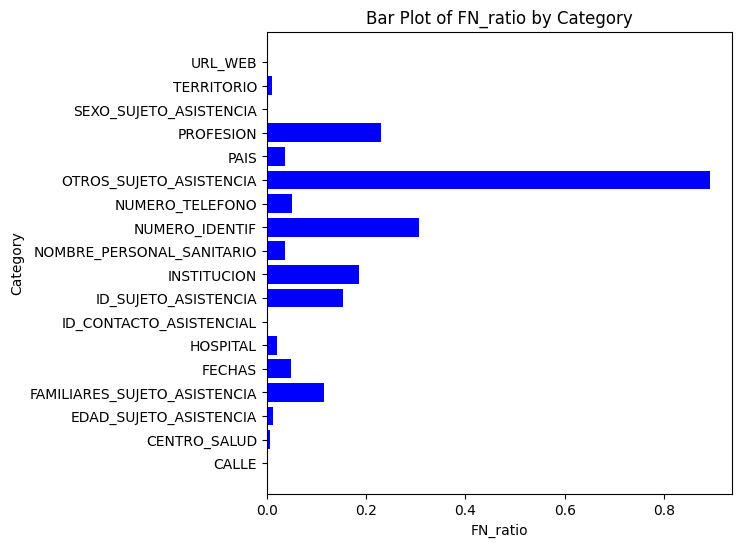

In [11]:
plt.figure(figsize=(6, 6))
plt.barh(FN_category_dfs['category'], FN_category_dfs['FN_ratio'], color='blue')  # Creating a horizontal bar plot

# Adding titles and labels
plt.title('Bar Plot of FN_ratio by Category')
plt.xlabel('FN_ratio')
plt.ylabel('Category')

# Displaying the plot
plt.show()

In [ ]:
# total cost= approx $25

# Viewing examples

In [32]:
otros_index_list

[4,
 87,
 105,
 109,
 121,
 137,
 180,
 246,
 280,
 314,
 367,
 380,
 449,
 767,
 769,
 796,
 806,
 847,
 884,
 906,
 960,
 1045,
 1178,
 1235,
 1255,
 1379,
 1380,
 1387,
 1410,
 1411]

In [33]:
identif_index_list

[82,
 116,
 142,
 146,
 148,
 149,
 154,
 161,
 162,
 167,
 171,
 174,
 177,
 179,
 180,
 182,
 185,
 189,
 199,
 201,
 204,
 216,
 235,
 237,
 244,
 251,
 252,
 253,
 283,
 362,
 425,
 444,
 455,
 460,
 475,
 488,
 494,
 634,
 701,
 709,
 811,
 1158,
 1225,
 1414,
 1415,
 1425,
 1428,
 1444,
 1457,
 1462,
 1483,
 1500,
 1506,
 1507,
 1522]

In [74]:
a=180
print(df['txtname'][a])
print('====================')
print(pd.read_csv(ann_path+df['txtname'][a].replace('txt','csv')))
print('====================')
print('recall',df2['recall'][a])
print('precision',df2['precision'][a])
print('====================')
print(df2['Masked'][a])

CARMEN-I_IA_EVOL_135.txt
            NUMERO_IDENTIF   472   475     9.9
0                   FECHAS   638   642    21/1
1                   FECHAS   654   658    26/1
2                   FECHAS   691   695    27/1
3                   FECHAS   708   712    27/1
4                   FECHAS   735   739    27/1
5                   FECHAS   752   756    28/1
6           NUMERO_IDENTIF  1219  1223    O201
7                   FECHAS  1263  1267    27/1
8  OTROS_SUJETO_ASISTENCIA  1359  1365  ensayo
9                   FECHAS  1628  1632    28/1
recall 0.7272727272727273
precision 0.7272727272727273
* NOTA INGRESO S. INTERNACIONAL:
Valoración COVID19 de paciente de 54 a con AP de HTA que acude por cuadro de 6 días de evolución de dinea progresiva, tos y febrícula,ydeposiciones diarreicas.
En la Rx de tórax se aprecia un infiltrado intersticial bilateral con imagen de condensación en LM. Sat b O2 93%, del 95% con 2lx' en GN En la analítica se evindencian parámetros compatibles con COVID19(elevaci

In [75]:
print(df2['Prediction_processed'][a])

* NOTA INGRESO S. INTERNACIONAL:
Valoración COVID19 de [**paciente**] de [**54 a**] con AP de HTA que acude por cuadro de 6 días de evolución de dinea progresiva, tos y febrícula,ydeposiciones diarreicas.
En la Rx de tórax se aprecia un infiltrado intersticial bilateral con imagen de condensación en LM. Sat b O2 93%, del 95% con 2lx' en GN En la analítica se evindencian parámetros compatibles con COVID19(elevación de PCR, LDH y DD).
Valorado el [**paciente**], se decide ingreso en la 9.9 (comentado con el responsable de planta y gestor de camas COVID)
    
* EVOL. EN SALA DE ENF. INFECCIOSAS:
1. NEUMONIA BILATERAL POR SARS-COV2
- Inicio síntomas: [**21/1**]
- Ingreso: [**26/1**]
- Tratamiento: Ivermectina 12mg [**27/1**]; Remdesivir [**27/1**] + Siltuximab (SILCOR) [**27/1**]; DXM 6 mg/d [**28/1**].
A su llegada a Ucias. Paciente con estado general conservado, eupneico con Sat basal del 93% que se corrige hasta el 95% con LN2L.
En la Rx de tórax se aprecia un infiltrado intersticial bi

In [68]:
masked=df2['Masked'][a]
generated=df2['Prediction_processed'][a]

In [69]:
masked=masked.replace('\n','')
generated=generated.replace('\n','')

ground_truth_matches = re.finditer(r'\[\*\*(.*?)\*\*\]', masked)
ground_truth_positions = {}
cnt=0
for match in ground_truth_matches:
    start = match.start(1)-(cnt*2+1)*3  # start of the group (excluding [**)
    end = match.end(1)-(cnt*2+1)*3
    cnt+=1# end of the group (excluding **])
    ground_truth_positions[(start, end)] = replace_special_characters(match.group(1))

predictions_matches = re.finditer(r'\[\*\*(.*?)\*\*\]', generated)
predictions_positions = {}
cnt=0
for match in predictions_matches:
    start = match.start(1)-(cnt*2+1)*3  # start of the group (excluding [**)
    end = match.end(1)-(cnt*2+1)*3
    cnt+=1# end of the group (excluding **])
    predictions_positions[(start, end)] = replace_special_characters(match.group(1))

totalwordcnt_ground_truth = len(ground_truth_positions)
score_total=0
for pos_g in ground_truth_positions:
    for pos_p in predictions_positions:
        if (pos_p[0]<=pos_g[0] and pos_p[1]>=pos_g[1]) or (pos_p[0]>=pos_g[0] and pos_p[1]<=pos_g[1]):
            score_temp = partial_score(ground_truth_positions[pos_g],predictions_positions[pos_p])
            score_total += score_temp
            print(score_temp,ground_truth_positions[pos_g])

score_total = score_total/totalwordcnt_ground_truth
recall = score_total

totalwordcnt_predictions = len(predictions_positions)
score_total=0
for pos_p in predictions_positions:
    for pos_g in ground_truth_positions:
        if (pos_g[0]<=pos_p[0] and pos_g[1]>=pos_p[1]) or (pos_g[0]>=pos_p[0] and pos_g[1]<=pos_p[1]):
            score_temp = partial_score(predictions_positions[pos_p],ground_truth_positions[pos_g])
            score_total += score_temp

score_total = score_total/totalwordcnt_predictions
precision = score_total

f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0



1.0 Varón
1.0 92 años
1.0 29 08
1.0 11 09
1.0 21
1.0 13 09
1.0 14 09
1.0 16 09
1.0 21
1.0 16 09
1.0 26
1.0 21 09
1.0 miércoles 22 de septiembre


In [70]:
ground_truth_positions

{(32, 37): 'C12 7',
 (38, 43): 'Varón',
 (47, 54): '92 años',
 (401, 406): '29 08',
 (410, 415): '11 09',
 (462, 464): '21',
 (465, 470): '13 09',
 (496, 501): '14 09',
 (503, 508): '16 09',
 (530, 535): '16 09',
 (554, 556): '21',
 (557, 562): '16 09',
 (577, 579): '26',
 (580, 585): '21 09',
 (1976, 2002): 'miércoles 22 de septiembre'}

In [71]:
predictions_positions

{(38, 43): 'Varón',
 (47, 54): '92 años',
 (401, 406): '29 08',
 (410, 415): '11 09',
 (462, 470): '21 13 09',
 (496, 508): '14 09  16 09',
 (554, 562): '21 16 09',
 (577, 585): '26 21 09',
 (1976, 2002): 'miércoles 22 de septiembre'}